# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import re  #import regular expression libraries 
import nltk
from nltk.corpus import stopwords
from transformers import (
    BertTokenizer, BertModel,
    RobertaTokenizer, RobertaModel,
    DistilBertTokenizer, DistilBertModel,
    logging as transformers_logging
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import pickle
from wordcloud import WordCloud

# Setup
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

transformers_logging.set_verbosity_error()
warnings.filterwarnings("ignore", message="Some weights of RobertaModel were not initialized")


2025-08-19 13:44:45.600106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755611085.829468      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755611085.893118      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Load Dataset 

In [2]:
# Load dataset
df = pd.read_csv("/kaggle/input/resume-dataset/UpdatedResumeDataSet.csv")


# 3. Exploratory Data Analysis (EDA)

In [3]:
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [4]:
df.shape

(962, 2)

In [5]:
category = df['Category'].value_counts().reset_index()
category

,Category,count
0,Java Developer,84
1,Testing,70
2,DevOps Engineer,55
3,Python Developer,48
4,Web Designing,45
5,HR,44
6,Hadoop,42
7,Blockchain,40
8,ETL Developer,40
9,Operations Manager,40


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


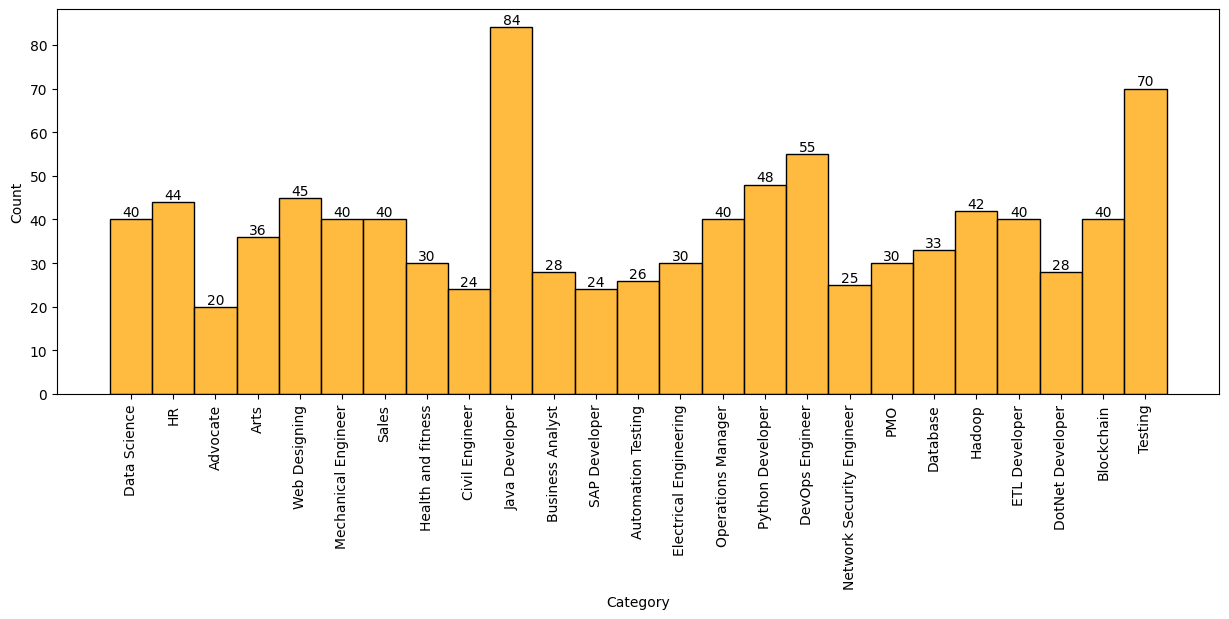

In [6]:
plt.figure(figsize=(15,5))
ax = sns.histplot(data=df, x='Category', stat='count', color='orange')
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2, i.get_height(), 
            int(i.get_height()), 
            ha='center', va='bottom')
plt.xticks(rotation=90)
plt.show()

In [7]:
counts = df["Category"].value_counts()
labels = df["Category"].unique()
labels



array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

In [8]:
noOfCategories = df["Category"].nunique()
noOfCategories

25

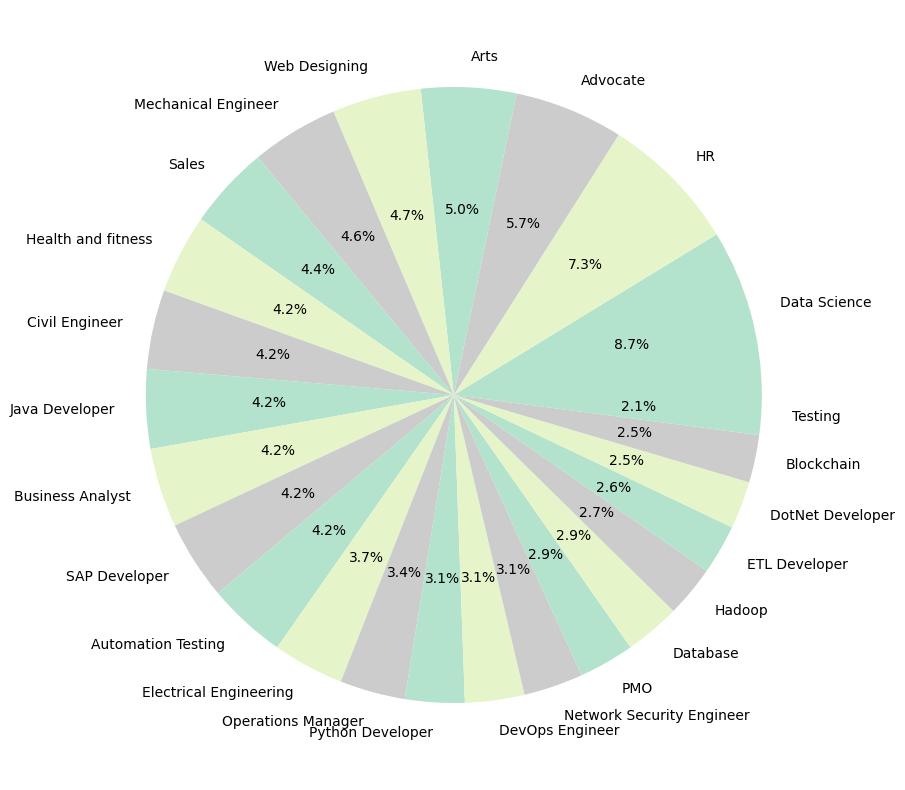

In [9]:
plt.figure(figsize=(15,10))
plt.pie(counts, labels=labels, autopct="%1.1f%%", colors=plt.cm.Pastel2(np.linspace(0,1,3)))
plt.show()

# 4. Data Preprocessing
## 4.1 Text Preprocessing
 This step cleans all the urls, special characters, emails/mention and stop words

In [10]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    # Remove carriage returns and line feeds
    text = text.replace('\r', '').replace('\n', ' ')
    
    # Remove non-ASCII characters
    text = text.encode('ascii', errors='ignore').decode('utf-8')
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove emails
    text = re.sub(r'\b\w+@\w+\.\w+\b', '', text)
    # Remove @ mentions
    text = re.sub(r'@\S+', '', text)
    # Remove special characters (keep alphanumeric and spaces)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Collapse multiple spaces into one
    text = re.sub(r'\s+', ' ', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

In [11]:
print("Sample Original Resume:\n")
df["Resume"][0]

Sample Original Resume:



'Skills * Programming Languages: Python (pandas, numpy, scipy, scikit-learn, matplotlib), Sql, Java, JavaScript/JQuery. * Machine learning: Regression, SVM, NaÃ¯ve Bayes, KNN, Random Forest, Decision Trees, Boosting techniques, Cluster Analysis, Word Embedding, Sentiment Analysis, Natural Language processing, Dimensionality reduction, Topic Modelling (LDA, NMF), PCA & Neural Nets. * Database Visualizations: Mysql, SqlServer, Cassandra, Hbase, ElasticSearch D3.js, DC.js, Plotly, kibana, matplotlib, ggplot, Tableau. * Others: Regular Expression, HTML, CSS, Angular 6, Logstash, Kafka, Python Flask, Git, Docker, computer vision - Open CV and understanding of Deep learning.Education Details \r\n\r\nData Science Assurance Associate \r\n\r\nData Science Assurance Associate - Ernst & Young LLP\r\nSkill Details \r\nJAVASCRIPT- Exprience - 24 months\r\njQuery- Exprience - 24 months\r\nPython- Exprience - 24 monthsCompany Details \r\ncompany - Ernst & Young LLP\r\ndescription - Fraud Investigatio

In [12]:

#Apply clean text function to the actual dataset
df['modified_resume'] = df['Resume'].apply(lambda x : clean_text(x))

In [13]:
print("Sample Modified Resume:\n")
df['modified_resume'][0]

Sample Modified Resume:



'skills programming languages python pandas numpy scipy scikitlearn matplotlib sql java javascriptjquery machine learning regression svm nave bayes knn random forest decision trees boosting techniques cluster analysis word embedding sentiment analysis natural language processing dimensionality reduction topic modelling lda nmf pca neural nets database visualizations mysql sqlserver cassandra hbase elasticsearch d3js dcjs plotly kibana matplotlib ggplot tableau others regular expression html css angular 6 logstash kafka python flask git docker computer vision open cv understanding deep learningeducation details data science assurance associate data science assurance associate ernst young llp skill details javascript exprience 24 months jquery exprience 24 months python exprience 24 monthscompany details company ernst young llp description fraud investigations dispute services assurance technology assisted review tar technology assisted review assists accelerating review process run anal

### Visualization of Word Frequency in Resumes

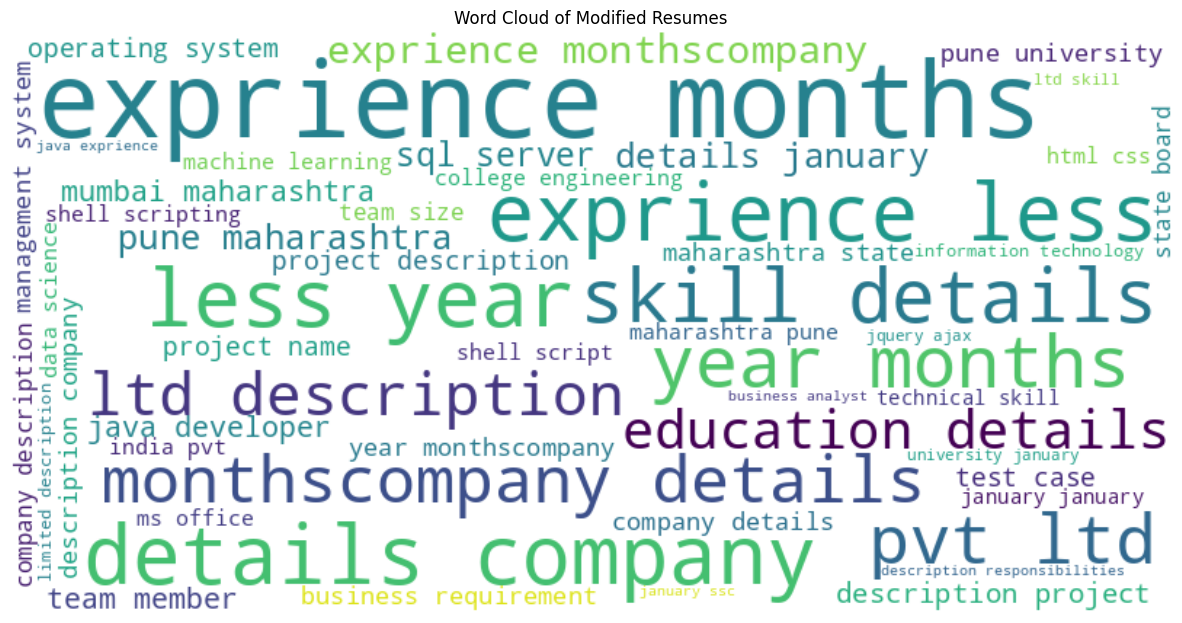

In [14]:
# Combine all cleaned resumes into a single string
text = ' '.join(df['modified_resume'].dropna())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      min_font_size=10).generate(text)
# Display the word cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title('Word Cloud of Modified Resumes')
plt.show()

The word cloud shows that the modified resumes emphasize Experience, Education Details, Company, and Months, indicating a focus on work history and duration. Key Skills like "Ms Office," "Java," "HTML," "CSS," and "Technical skill" etc. are prominent.

# 4. Train-Test Split

In [15]:
# Prepare data
Resume_content = df['modified_resume'].values  #word feature
Target = df['Category'].values

In [16]:
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    Resume_content, Target, test_size=0.2, random_state=42, stratify=Target
)

## 4.1 Embedding Generation Function:

In [17]:
# Function to get embeddings
def get_embeddings(texts, tokenizer, model, device='cuda' if torch.cuda.is_available() else 'cpu', batch_size=16):
    model = model.to(device)
    model.eval()
    embeddings = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(
            batch_texts.tolist(),
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors='pt'
        ).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # CLS token
        embeddings.append(batch_embeddings)
    
    return np.vstack(embeddings)


# 5. Buiding the models

The models use in experiment 3 are BERT, RoBERTa and DistilBERT to compare which one are better for classification

In [18]:
# Initialize models and tokenizers
models = {
    'BERT': {
        'tokenizer': BertTokenizer.from_pretrained('bert-base-uncased'),
        'model': BertModel.from_pretrained('bert-base-uncased'),
        'embeddings_train': None,
        'embeddings_test': None,
        'classifier': LogisticRegression(max_iter=1000, random_state=42),
        'train_accuracy': None,
        'test_accuracy': None,
        'precision': None,
        'recall': None,
        'f1_score': None
    },
    'RoBERTa': {
        'tokenizer': RobertaTokenizer.from_pretrained('roberta-base'),
        'model': RobertaModel.from_pretrained('roberta-base'),
        'embeddings_train': None,
        'embeddings_test': None,
        'classifier': LogisticRegression(max_iter=1000, random_state=42),
        'train_accuracy': None,
        'test_accuracy': None,
        'precision': None,
        'recall': None,
        'f1_score': None
    },
    'DistilBERT': {
        'tokenizer': DistilBertTokenizer.from_pretrained('distilbert-base-uncased'),
        'model': DistilBertModel.from_pretrained('distilbert-base-uncased'),
        'embeddings_train': None,
        'embeddings_test': None,
        'classifier': LogisticRegression(max_iter=1000, random_state=42),
        'train_accuracy': None,
        'test_accuracy': None,
        'precision': None,
        'recall': None,
        'f1_score': None
    }
}

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

# 6. Model Training and Evaluation:


Training BERT...


Generating embeddings: 100%|██████████| 13/13 [02:40<00:00, 12.32s/it]



Classification Report for BERT:
                           precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         4
                     Arts       1.00      1.00      1.00         7
       Automation Testing       1.00      1.00      1.00         5
               Blockchain       1.00      1.00      1.00         8
         Business Analyst       0.86      1.00      0.92         6
           Civil Engineer       1.00      1.00      1.00         5
             Data Science       1.00      1.00      1.00         8
                 Database       1.00      1.00      1.00         7
          DevOps Engineer       1.00      0.91      0.95        11
         DotNet Developer       1.00      1.00      1.00         5
            ETL Developer       1.00      1.00      1.00         8
   Electrical Engineering       1.00      1.00      1.00         6
                       HR       1.00      1.00      1.00         9
                   Hadoop   

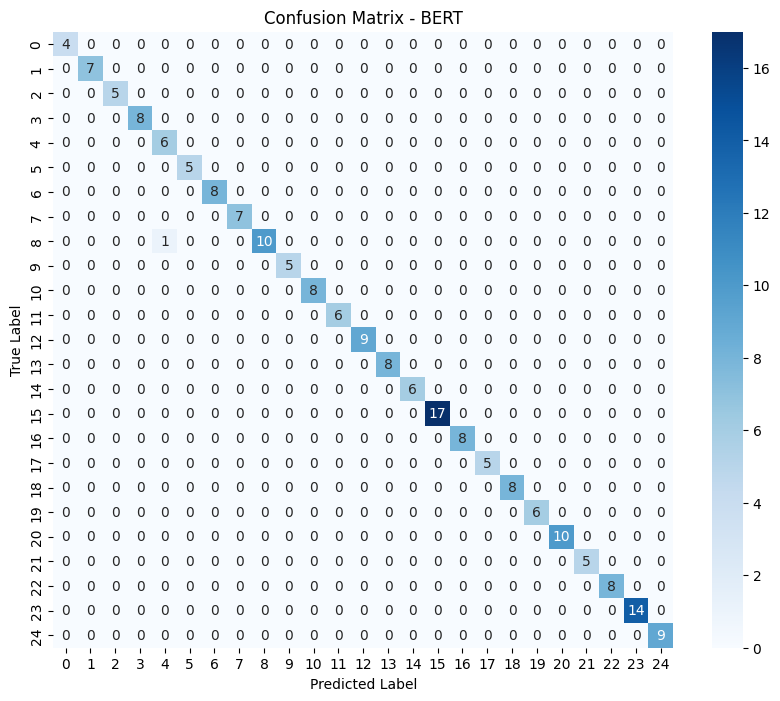


Training RoBERTa...


Generating embeddings: 100%|██████████| 13/13 [02:38<00:00, 12.16s/it]



Classification Report for RoBERTa:
                           precision    recall  f1-score   support

                 Advocate       1.00      0.75      0.86         4
                     Arts       1.00      0.71      0.83         7
       Automation Testing       1.00      0.40      0.57         5
               Blockchain       1.00      1.00      1.00         8
         Business Analyst       1.00      0.50      0.67         6
           Civil Engineer       1.00      0.60      0.75         5
             Data Science       1.00      0.50      0.67         8
                 Database       1.00      1.00      1.00         7
          DevOps Engineer       0.91      0.91      0.91        11
         DotNet Developer       1.00      0.20      0.33         5
            ETL Developer       1.00      0.62      0.77         8
   Electrical Engineering       1.00      0.83      0.91         6
                       HR       0.82      1.00      0.90         9
                   Hadoop

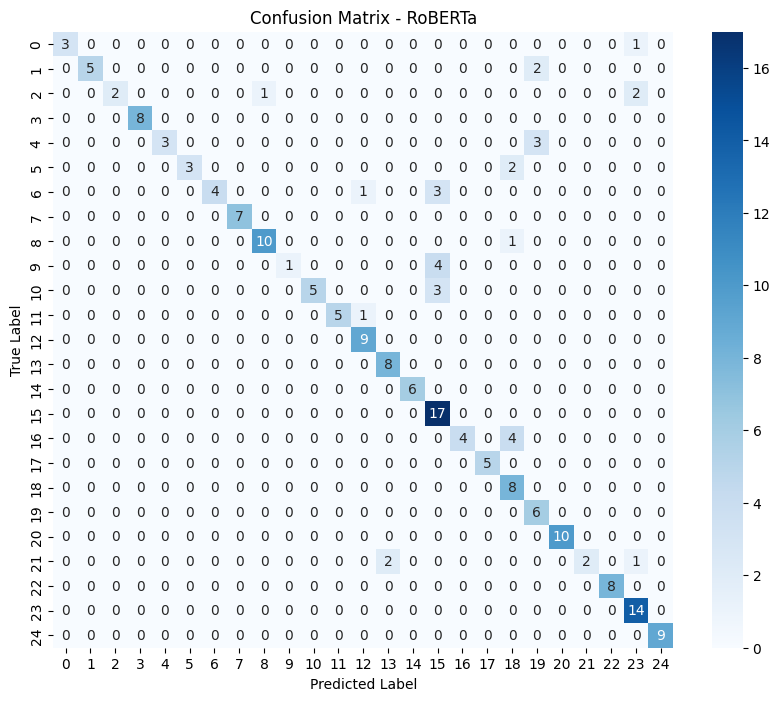


Training DistilBERT...


Generating embeddings: 100%|██████████| 13/13 [01:20<00:00,  6.20s/it]



Classification Report for DistilBERT:
                           precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         4
                     Arts       1.00      1.00      1.00         7
       Automation Testing       1.00      1.00      1.00         5
               Blockchain       1.00      1.00      1.00         8
         Business Analyst       0.86      1.00      0.92         6
           Civil Engineer       1.00      1.00      1.00         5
             Data Science       1.00      1.00      1.00         8
                 Database       1.00      1.00      1.00         7
          DevOps Engineer       1.00      0.91      0.95        11
         DotNet Developer       1.00      1.00      1.00         5
            ETL Developer       1.00      1.00      1.00         8
   Electrical Engineering       1.00      1.00      1.00         6
                       HR       1.00      1.00      1.00         9
                   Had

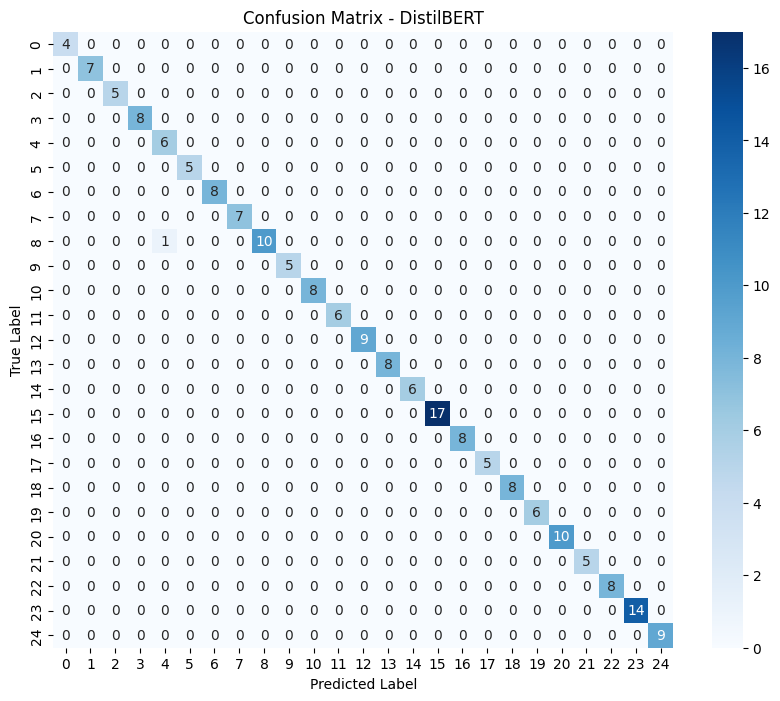

In [19]:
# Train and evaluate models
device = 'cuda' if torch.cuda.is_available() else 'cpu'
results = []

for model_name, model_info in models.items():
    print("=" * 80)
    print(f"\nTraining {model_name}...")
    
    # Get embeddings
    model_info['embeddings_train'] = get_embeddings(
        X_train_texts, model_info['tokenizer'], model_info['model'], device
    )
    model_info['embeddings_test'] = get_embeddings(
        X_test_texts, model_info['tokenizer'], model_info['model'], device
    )
    
    # Train classifier
    model_info['classifier'].fit(model_info['embeddings_train'], y_train)
    
    # Calculate metrics
    train_pred = model_info['classifier'].predict(model_info['embeddings_train'])
    test_pred = model_info['classifier'].predict(model_info['embeddings_test'])
    
    model_info['train_accuracy'] = accuracy_score(y_train, train_pred)
    model_info['test_accuracy'] = accuracy_score(y_test, test_pred)
    model_info['precision'] = precision_score(y_test, test_pred, average='weighted')
    model_info['recall'] = recall_score(y_test, test_pred, average='weighted')
    model_info['f1_score'] = f1_score(y_test, test_pred, average='weighted')
    
    # Store results
    results.append({
        'Model': model_name,
        'Train Accuracy': model_info['train_accuracy'],
        'Test Accuracy': model_info['test_accuracy'],
        'Precision': model_info['precision'],
        'Recall': model_info['recall'],
        'F1 Score': model_info['f1_score']
    })
    
    # Print classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, test_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, test_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    


## 6.1 Model Performance Summary Table:

In [20]:
# Create comprehensive summary table
results_df = pd.DataFrame(results)
print("\nComprehensive Model Performance Summary:")
display(results_df[['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score']])




Comprehensive Model Performance Summary:


,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score
0,BERT,1.000000,0.994819,0.995559,0.994819,0.994895
1,RoBERTa,0.889467,0.839378,0.895832,0.839378,0.829357
2,DistilBERT,1.000000,0.994819,0.995559,0.994819,0.994895


## 6.2 Models Performance (Training & Testing)

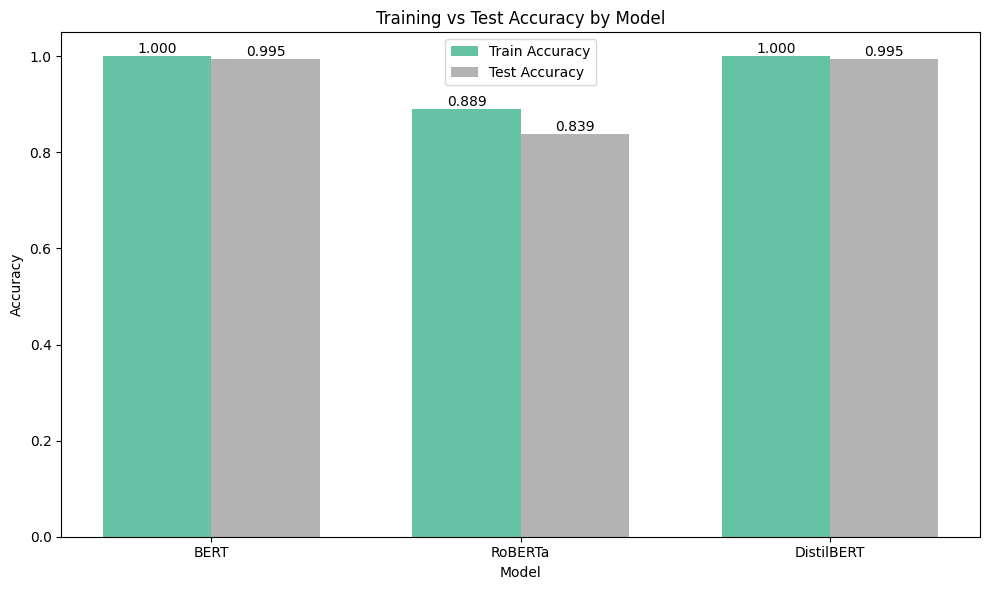

In [21]:
# Plot training and test accuracies
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(models))
colors = plt.cm.Set2(np.linspace(0, 1, 2))  # Use Set2 color palette

train_bars = plt.bar(index, [r['Train Accuracy'] for r in results], bar_width, label='Train Accuracy', color=colors[0])
test_bars = plt.bar(index + bar_width, [r['Test Accuracy'] for r in results], bar_width, label='Test Accuracy', color=colors[1])

# Add text annotations on top of bars
for bars in [train_bars, test_bars]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, height,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=10
        )

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Training vs Test Accuracy by Model')
plt.xticks(index + bar_width/2, models.keys())
plt.legend()
plt.tight_layout()
plt.show()

# 7. Save the model:

In [22]:
# Find and save best model
best_model = max(results, key=lambda x: x['Test Accuracy'])
best_model_name = best_model['Model']
print(f"\nBest Model: {best_model_name} with Test Accuracy: {best_model['Test Accuracy']:.4f}")

# Save the best model
best_model_info = models[best_model_name]
with open('best_resume_classifier.pkl', 'wb') as f:
    pickle.dump({
        'model_name': best_model_name,
        'classifier': best_model_info['classifier'],
        'tokenizer': best_model_info['tokenizer'],
        'transformer_model': best_model_info['model']
    }, f)


Best Model: BERT with Test Accuracy: 0.9948


# 8. Prediction of the best Model:

In [23]:


# Predict a sample case
sample_resume = X_test_texts[0]
sample_true_label = y_test[0]

# Get embedding for sample
sample_embedding = get_embeddings(
    np.array([sample_resume]),
    best_model_info['tokenizer'],
    best_model_info['model'],
    device
)

# Predict
sample_prediction = best_model_info['classifier'].predict(sample_embedding)[0]
print(f"\nSample Prediction:")
print(f"Original Resume: {sample_resume[:200]}...")
print("=" * 80)
print(f"True Label: {sample_true_label}")
print(f"Predicted Label: {sample_prediction}")

Generating embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Sample Prediction:
Original Resume: education details january 2015 bachelor engineering extc mumbai maharashtra mumbai university january 2012 diploma industrial electronics vashi maharashtra fr agnel polytechnic etl developer etl devel...
True Label: ETL Developer
Predicted Label: ETL Developer
